In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
import cv2
import os

# Define paths to image folders
train_low_folder = "/home/dgreen/sem2/dl/finalProject/LOL-v2/LOL-v2/Real_captured/Train/Low"  # Path to folder containing low-resolution training images
train_high_folder = "/home/dgreen/sem2/dl/finalProject/LOL-v2/LOL-v2/Real_captured/Train/Normal"  # Path to folder containing high-resolution training images
eval_low_folder = "/home/dgreen/sem2/dl/finalProject/LOL-v2/LOL-v2/Real_captured/Test/Low"  # Path to folder containing low-resolution evaluation images
eval_high_folder = "/home/dgreen/sem2/dl/finalProject/LOL-v2/LOL-v2/Real_captured/Test/Normal"  # Path to folder containing high-resolution evaluation images


# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [86]:
train_low_images_list = []
train_high_images_list = []
eval_low_images_list = []
eval_high_images_list = []

for filename in os.listdir(train_low_folder):
    if "png" in filename.strip().split(".")[-1]:
        train_low_images_list.append(filename)

for filename in os.listdir(train_high_folder):
    if "png" in filename.strip().split(".")[-1]:
        train_high_images_list.append(filename)

for filename in os.listdir(eval_low_folder):
    if "png" in filename.strip().split(".")[-1]:
        eval_low_images_list.append(filename)

for filename in os.listdir(eval_high_folder):
    if "png" in filename.strip().split(".")[-1]:
        eval_high_images_list.append(filename)

In [87]:
train_low_images_list = sorted(train_low_images_list)
train_high_images_list = sorted(train_high_images_list)
eval_low_images_list = sorted(eval_low_images_list)
eval_high_images_list = sorted(eval_high_images_list)

In [88]:
print(train_low_images_list[0],train_high_images_list[0])

low00001.png normal00001.png


In [89]:
# Load low-resolution and high-resolution images using OpenCV
train_low_images = [cv2.imread(os.path.join(train_low_folder, filename)) for filename in train_low_images_list]
train_high_images = [cv2.imread(os.path.join(train_high_folder, filename)) for filename in train_high_images_list]
eval_low_images = [cv2.imread(os.path.join(eval_low_folder, filename)) for filename in eval_low_images_list]
eval_high_images = [cv2.imread(os.path.join(eval_high_folder, filename)) for filename in eval_high_images_list]

In [90]:
# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, low_res_images, high_res_images, transform=None):
        self.low_res_images = low_res_images
        self.high_res_images = high_res_images
        self.transform = transform

    def __len__(self):
        return len(self.low_res_images)

    def __getitem__(self, idx):
        low_res_image = self.low_res_images[idx]
        high_res_image = self.high_res_images[idx]

        if self.transform:
            low_res_image = self.transform(low_res_image)
            high_res_image = self.transform(high_res_image)

        return low_res_image.to(device), high_res_image.to(device)

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Create custom datasets
train_dataset = CustomDataset(train_low_images, train_high_images, transform=transform)
eval_dataset = CustomDataset(eval_low_images, eval_high_images, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=1)

In [91]:
# Define the model architecture
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.batchnorm = nn.BatchNorm2d(channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.activation(x)
        x = self.conv1(x)
        x = self.batchnorm(x)
        x += residual
        x = self.activation(x)
        return x

class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.residual_blocks = nn.ModuleList([ResidualBlock(64) for _ in range(8)])
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.activation(x)
        for block in self.residual_blocks:
            x = block(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.sigmoid(x)
        return x

In [9]:
# Initialize the model and move it to the device
model = DiffusionModel().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(50):
    model.train()
    running_loss = 0.0
    print("Entering inner for")
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_dataset)}")

Entering inner for
Epoch 1, Training Loss: 0.18740319378176604
Entering inner for
Epoch 2, Training Loss: 0.17999692040350943
Entering inner for
Epoch 3, Training Loss: 0.17753362287976746
Entering inner for
Epoch 4, Training Loss: 0.17614821658614369
Entering inner for
Epoch 5, Training Loss: 0.17499289402254303
Entering inner for
Epoch 6, Training Loss: 0.17448159255065748
Entering inner for
Epoch 7, Training Loss: 0.17366087649974576
Entering inner for
Epoch 8, Training Loss: 0.1736774087068456
Entering inner for
Epoch 9, Training Loss: 0.1734203259637701
Entering inner for
Epoch 10, Training Loss: 0.17274731492923764
Entering inner for
Epoch 11, Training Loss: 0.17250746664427577
Entering inner for
Epoch 12, Training Loss: 0.17261995493565485
Entering inner for
Epoch 13, Training Loss: 0.17163153512589904
Entering inner for
Epoch 14, Training Loss: 0.17175840311352547
Entering inner for
Epoch 15, Training Loss: 0.1717061406131212
Entering inner for
Epoch 16, Training Loss: 0.171585

In [10]:
# Evaluate the model
model.eval()
eval_loss = 0.0
with torch.no_grad():
    for inputs, targets in eval_loader:
        outputs = model(inputs)
        eval

In [11]:
torch.save(model.state_dict(), '/home/dgreen/sem2/dl/finalProject/deepLearning/diffusion_model.pth')

In [92]:
model = DiffusionModel().to(device)
model.load_state_dict(torch.load('diffusion_model.pth'))

<All keys matched successfully>

432


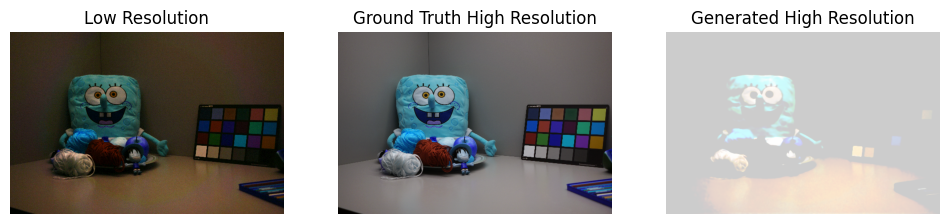

In [113]:
import matplotlib.pyplot as plt
from skimage import exposure
# Test the model on random images
model.eval()
random_idx = np.random.randint(len(train_dataset))
print(random_idx)
random_low_res, random_high_res = train_dataset[468]
random_low_res = random_low_res.unsqueeze(0)  # Add batch dimension
random_high_res = random_high_res.unsqueeze(0)  # Add batch dimension
with torch.no_grad():
    output_image = model(random_low_res)
output_image_np = output_image.cpu().numpy()  # Move output to CPU memory and convert to NumPy array
output_image_np = np.transpose(output_image_np.squeeze(0), (1, 2, 0))  # Remove batch dimension and transpose axes
normalized_data_low = (random_low_res - random_low_res.min()) / (random_low_res.max() - random_low_res.min())
normalized_data_high = (random_high_res - random_high_res.min()) / (random_high_res.max() - random_high_res.min())

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))


def adjust_color_balance(image):
    # Example: Apply a simple color balance adjustment by increasing the red channel
    image[:,:,:] *= 1.25  # Increase red channel

    # Clip values to ensure they are in the valid range [0, 1]
    image = np.clip(image, 0, 1)
    
    return image

# Move tensors to CPU memory and convert to NumPy arrays
low_res_np = normalized_data_low.squeeze(0).permute(1, 2, 0).cpu().numpy()
high_res_np = normalized_data_high.squeeze(0).permute(1, 2, 0).cpu().numpy()
output_image_np = output_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
output_image_np_normalized = (output_image_np - output_image_np.min()) / (output_image_np.max() - output_image_np.min())
# output_image_np_adjusted = adjust_color_balance(output_image_np_normalized)
output_image_np_adjusted = exposure.equalize_hist(output_image_np_normalized)
axes[0].imshow(low_res_np)
axes[0].set_title('Low Resolution')
axes[0].axis('off')
axes[1].imshow(high_res_np)
axes[1].set_title('Ground Truth High Resolution')
axes[1].axis('off')
axes[2].imshow(output_image_np_adjusted)
axes[2].set_title('Generated High Resolution') 
axes[2].axis('off')

plt.show()